In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [4]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [5]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [6]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [7]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=25)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [8]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
df_buy_signal=pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    #display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-90:].mean() ,6 )
    #print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-90:].mean() ,6 )
    #print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((cp,df_tmp.iloc[-1].Price,x,y )),
                          columns=["Crypto_Pair",'Price','Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    r0=df_tmp.iloc[-1].Price
    r1= ( df_tmp.iloc[-1].Price+(df_tmp.iloc[-1].Price*0.05) ) 
    r2=float(df_tmp_2["Bol_Up_30"].values) 
    df_tmp_2["%change"]=((r2-r0)/ abs(r0) ) *100
    #print(r1)
    #print(r2)
    if r1<=r2:
        print("BUY_signal")
        df_buy_signal=df_buy_signal.append(df_tmp_2)
        #display(df_buy_signal)
        
#---------------------------------------------------------------------------
#display(df_buy_signal)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands",final_text)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands","")

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
MATI

In [9]:
display(df_buy_signal) 

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30,%change
0,DOGE-USD,0.07514968514442444,0.086192,0.074781,14.693761
0,SHIB-USD,1.1046162398997694e-05,1.2e-05,1e-05,8.635013
0,LTC-USD,84.9186019897461,91.022343,78.862921,7.187755


In [10]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [11]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

In [12]:
display(df_buy_signal)

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30,%change
0,DOGE-USD,0.07514968514442444,0.086192,0.074781,14.693761
0,SHIB-USD,1.1046162398997694e-05,1.2e-05,1e-05,8.635013
0,LTC-USD,84.9186019897461,91.022343,78.862921,7.187755


In [13]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


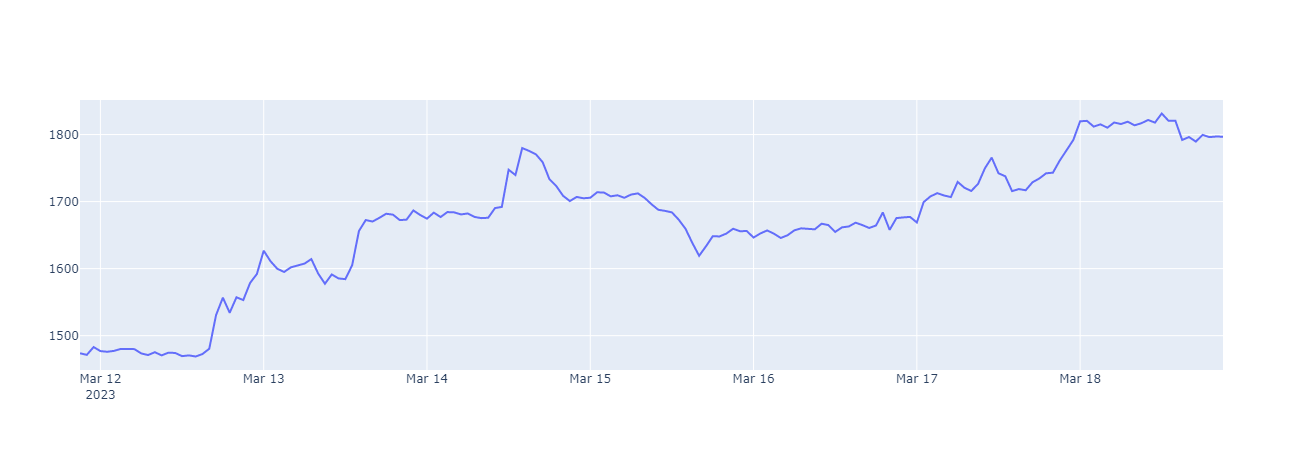

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


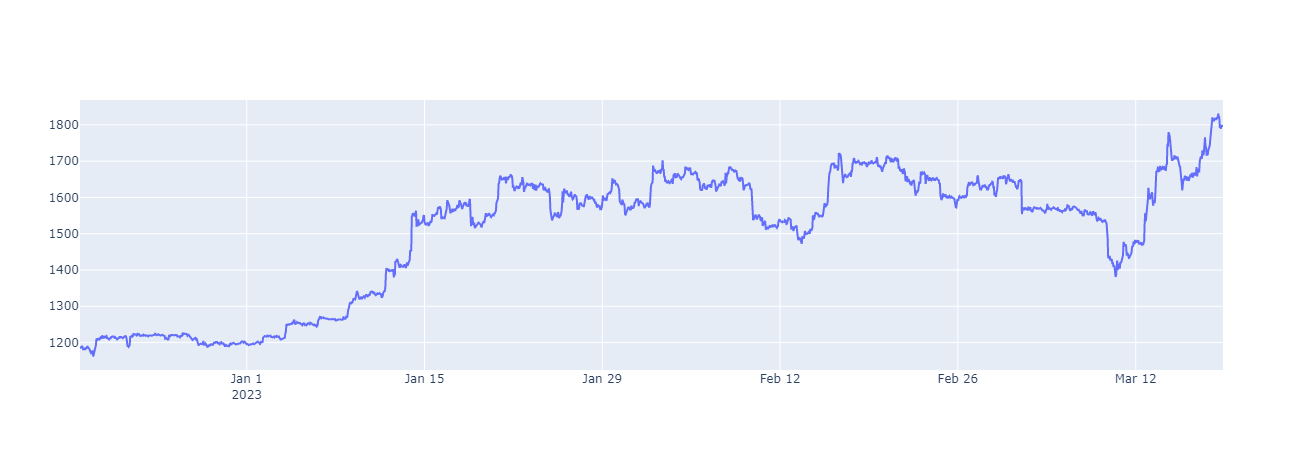

In [14]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [15]:

html = dfx.to_html()
# Write the HTML to a file
with open('crypto_change.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,5892.3051,233.2432,423.1492,-34.4400,63.4969,11.2950,33.7449,-0.8501
1,ETH-USD,459.9415,233.5715,1464.5481,-38.9965,51.7910,6.4385,21.9175,-1.2627
2,BNB-USD,16887.4869,3677.7866,3242.0023,-14.9540,35.7954,7.2400,22.3101,-1.6043
3,XRP-USD,74.8942,-42.2606,165.8099,-52.3500,8.5505,-3.3426,4.2626,-0.2238
4,HEX-USD,52094.1520,52094.1520,31326.7606,-24.0331,245.7906,65.7634,33.4869,-0.7528
5,ADA-USD,977.4311,121.1578,1263.0763,-59.5341,29.4358,-14.7215,13.3157,-1.8705
6,MATIC-USD,27116.6931,27116.6931,13474.5713,-19.7595,48.3959,-19.0570,14.8285,-1.9690
7,STETH-USD,203.3833,203.3833,203.3833,-39.2469,54.7319,6.8021,21.4869,1.1859


In [16]:
html = df_tmp_f.to_html()
# Write the HTML to a file
with open('crypto_bol.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-03-12,BTC-USD,22163.949219,23311.539075,19463.955903,-509.573581,-271.935299,Sell
2023-03-13,BTC-USD,24197.533203,24458.576916,18821.996745,-284.720379,-274.492315,Sell
2023-03-14,BTC-USD,24746.074219,25681.088636,18321.286364,-61.550407,-231.903934,Buy
2023-03-15,BTC-USD,24375.960938,26452.143173,18309.626358,84.474585,-168.62823,Buy
2023-03-16,BTC-USD,25052.789062,27115.990291,18985.712834,251.910944,-84.520395,Buy
2023-03-17,BTC-USD,27423.929688,28422.883094,19746.444473,569.373315,46.258347,Buy
2023-03-18,BTC-USD,27404.849609,28774.477205,21329.833063,810.086753,199.024028,Buy
2023-03-12,ETH-USD,1590.292969,1644.562133,1385.194599,-26.98635,-16.276071,Sell
2023-03-13,ETH-USD,1680.30896,1709.920804,1352.096006,-14.002792,-15.821415,Buy


In [17]:
from datetime import timedelta
df_ALGO = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_ALGO.index[-1]+ timedelta(days=1)

print(df_ALGO)

df_ALGO.loc[date, :] = [0]


print(df_ALGO.size)

df_ALGO['S1'] = df_ALGO['Close'].shift(1)
df_ALGO['SMA3'] = df_ALGO['Close'].rolling(3).mean().shift(1)
df_ALGO['SMA5'] = df_ALGO['Close'].rolling(5).mean().shift(1)
df_ALGO['SMA15'] = df_ALGO['Close'].rolling(15).mean().shift(1)
df_ALGO['SMA30'] = df_ALGO['Close'].rolling(30).mean().shift(1)

df_ALGO['S1'] = df_ALGO['S1'].fillna(0)
df_ALGO['SMA3'] = df_ALGO['SMA3'].fillna(0)
df_ALGO['SMA5'] = df_ALGO['SMA5'].fillna(0)
df_ALGO['SMA15'] = df_ALGO['SMA15'].fillna(0)
df_ALGO['SMA30'] = df_ALGO['SMA30'].fillna(0)



X = df_ALGO.iloc[:, 1:-1].values
y = df_ALGO.iloc[:, 0].values



df_ALGO

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
               Close
Date                
2019-06-21  3.201412
2019-06-22  2.158967
2019-06-23  1.890702
2019-06-24  1.383728
2019-06-25  1.537290
...              ...
2023-03-14  0.222731
2023-03-15  0.204872
2023-03-16  0.209169
2023-03-17  0.227241
2023-03-18  0.220912

[1367 rows x 1 columns]
1368


,Close,S1,SMA3,SMA5,SMA15,SMA30
Date,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.417027,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.811132,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2023-03-15,0.204872,0.222731,0.212684,0.203323,0.218735,0.241880
2023-03-16,0.209169,0.204872,0.213511,0.206429,0.216063,0.240553
2023-03-17,0.227241,0.209169,0.212257,0.210419,0.213260,0.239070


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)


ann=tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=12,
                              activation="relu"))

ann.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
ann.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['mse'])

# Fitting the ANN to the Training set
ann.fit(X_train, y_train ,batch_size = 50, epochs = 100)



Epoch 1/100
25/25 [==============================] - 1s 1ms/step - loss: 0.8084 - mse: 0.8084
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 0.6010 - mse: 0.6010
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 0.4110 - mse: 0.4110
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 0.2368 - mse: 0.2368
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 0.1130 - mse: 0.1130
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0551 - mse: 0.0551
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0387 - mse: 0.0387
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0353
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0337 - mse: 0.0337
Epoch 10/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0322 - mse: 0.0322
Epoch 11/100
25/25 [==============================] - 0s 1m

In [19]:
y_test[:-1]

array([0.36922199, 0.41486999, 0.42339   , 0.404138  , 0.41834399,
       0.33228999, 0.26510599, 0.31977201, 0.302286  , 0.27337599,
       0.26217699, 0.260948  , 0.28126699, 0.27616799, 0.26797599,
       0.29757699, 0.298621  , 0.25611299, 0.245101  , 0.24059901,
       0.246718  , 0.24211399, 0.2436    , 0.240537  , 0.240466  ,
       0.235966  , 0.240555  , 0.2483    , 0.240749  , 0.244508  ,
       0.23791599, 0.24011201, 0.236687  , 0.23409399, 0.22157   ,
       0.224718  , 0.22571699, 0.227487  , 0.223087  , 0.21865401,
       0.223529  , 0.220916  , 0.210502  , 0.185554  , 0.19459599,
       0.188841  , 0.17417499, 0.178975  , 0.17188101, 0.171767  ,
       0.170122  , 0.16837899, 0.16587199, 0.17150301, 0.169975  ,
       0.16724101, 0.165151  , 0.169008  , 0.17281801, 0.17746601,
       0.18119401, 0.184302  , 0.187093  , 0.183544  , 0.18949699,
       0.19438601, 0.19955   , 0.200688  , 0.204071  , 0.21073399,
       0.21252599, 0.221019  , 0.229522  , 0.240335  , 0.23428

In [20]:
import sklearn.metrics

predictions = ann.predict(X_test)
mse_no=sklearn.metrics.mean_squared_error(y_test[:-1],predictions[:-1])

print(mse_no)

print(y_test[-7:])
print(predictions[-7:])



0.0003223645731821584
[0.21293101 0.22273099 0.204872   0.209169   0.22724099 0.22091173
 0.        ]
[[0.21050055]
 [0.21319385]
 [0.22028764]
 [0.21306458]
 [0.21325722]
 [0.22565798]
 [0.22240421]]


In [21]:
type( y_test[-7:] )

print(y_test[-7:].shape)
print(predictions[-7:].shape)

z=y_test[-7:].reshape(7,1)

print(z.shape)

final=np.hstack((z,predictions[-7:] ))

final

(7,)
(7, 1)
(7, 1)


array([[0.21293101, 0.21050055],
       [0.22273099, 0.21319385],
       [0.204872  , 0.22028764],
       [0.209169  , 0.21306458],
       [0.22724099, 0.21325722],
       [0.22091173, 0.22565798],
       [0.        , 0.22240421]])

In [22]:
from datetime import datetime
# create an index list object
timestamp_list = pd.date_range(df_ALGO.index[-7], periods=7).tolist()

# create new dataframe
x1=pd.DataFrame(final, columns=["real","predict"],index=timestamp_list)
x1['diff'] = x1['real'] - (x1['predict'])
x1

,real,predict,diff
2023-03-13,0.212931,0.210501,0.002430
2023-03-14,0.222731,0.213194,0.009537
2023-03-15,0.204872,0.220288,-0.015416
2023-03-16,0.209169,0.213065,-0.003896
2023-03-17,0.227241,0.213257,0.013984
2023-03-18,0.220912,0.225658,-0.004746
2023-03-19,0.000000,0.222404,-0.222404


In [51]:
df_RNN = pd.DataFrame(columns=['Pair','p_units' ,'p_epoch' ,'p_batch_size' ,'prediction'])


df_alg = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_alg.index[-1]+ timedelta(days=1)
df_alg.loc[date, :] = [0]


for i in range (1,61):
    a="Close_"+str(i)
    #print(a)
    df_alg[a]=df_alg['Close'].shift(i)

df_alg=df_alg.fillna(0)
display(df_alg)


X = df_alg.iloc[:, 1:].values
y = df_alg.iloc[:, 0].values

print(y.shape)
print(y)
y=y.reshape(-1,1)
print(y)

def calc_LTSM( p_units ,p_epoch ,p_batch_size ):
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    X_scaled = sc.fit_transform(X)
    y_scaled = sc.fit_transform(y)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.1, shuffle=False)
    # Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # Importing the Keras libraries and packages
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    regressor = Sequential()
    
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs = p_epoch, batch_size = p_batch_size)
    
    lastElementIndex = len(X_test)-1
    # Removing the last element using slicing 
    X_pre = X_test[:lastElementIndex]
    y_pre = y_test[:lastElementIndex]
    X_pre = np.array(X_pre)
    X_pre = np.reshape(X_pre, (X_pre.shape[0], X_pre.shape[1], 1)) #   lenght of dataset,lenght of time_series , nof_input
    predicted_stock_price = regressor.predict(X_pre)
    #print("*****")
    #print(predicted_stock_price)
    
    index1 = len(X_test)-1
    index2 = len(X_test)
    X_final = X_test[index1:index2]
    y_final = y_test[index1:index2]
    X_final = np.array(X_final)
    X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], 1))
    
    print(y_final)
    print("Params: "+str(p_units)+" "+str(p_epoch)+" "+str(p_batch_size) )
    predicted_stock_price = regressor.predict(X_final)
    predicted_stock_price_f = sc.inverse_transform(predicted_stock_price)
    
    row1 = pd.Series(["ALGO-USD",p_units ,p_epoch ,p_batch_size,predicted_stock_price_f] ,index=df_RNN.columns )
    print(row1)
    df_RNN.loc[len(df_RNN.index)] = row1
    display(df_RNN)
    return predicted_stock_price_f



x1=calc_LTSM(10,1000,300)
print(x1)
x2=calc_LTSM(10,2000,300)
print(x2)
x3=calc_LTSM(10,3000,300)
print(x3)



display(df_RNN)
print(df_RNN.prediction.mean)

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Close_51,Close_52,Close_53,Close_54,Close_55,Close_56,Close_57,Close_58,Close_59,Close_60
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-15,0.204872,0.222731,0.212931,0.202391,0.189221,0.189342,0.193574,0.202328,0.217646,0.225965,...,0.250303,0.246711,0.239667,0.239776,0.217528,0.209594,0.229497,0.234289,0.240335,0.229522
2023-03-16,0.209169,0.204872,0.222731,0.212931,0.202391,0.189221,0.189342,0.193574,0.202328,0.217646,...,0.237040,0.250303,0.246711,0.239667,0.239776,0.217528,0.209594,0.229497,0.234289,0.240335
2023-03-17,0.227241,0.209169,0.204872,0.222731,0.212931,0.202391,0.189221,0.189342,0.193574,0.202328,...,0.245368,0.237040,0.250303,0.246711,0.239667,0.239776,0.217528,0.209594,0.229497,0.234289


(1368,)
[3.20141196 2.15896702 1.89070201 ... 0.22724099 0.22033185 0.        ]
[[3.20141196]
 [2.15896702]
 [1.89070201]
 ...
 [0.22724099]
 [0.22033185]
 [0.        ]]
Epoch 1/1000
5/5 [==============================] - 7s 120ms/step - loss: 0.0671
Epoch 2/1000
5/5 [==============================] - 1s 120ms/step - loss: 0.0433
Epoch 3/1000
5/5 [==============================] - 1s 122ms/step - loss: 0.0268
Epoch 4/1000
5/5 [==============================] - 1s 121ms/step - loss: 0.0198
Epoch 5/1000
5/5 [==============================] - 1s 122ms/step - loss: 0.0199
Epoch 6/1000
5/5 [==============================] - 1s 119ms/step - loss: 0.0190
Epoch 7/1000
5/5 [==============================] - 1s 125ms/step - loss: 0.0165
Epoch 8/1000
5/5 [==============================] - 1s 121ms/step - loss: 0.0155
Epoch 9/1000
5/5 [==============================] - 1s 121ms/step - loss: 0.0158
Epoch 10/1000
5/5 [==============================] - 1s 124ms/step - loss: 0.0154
Epoch 11/1000
5/5 [

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,1000,300,[[0.20894873]]


[[0.20894873]]
Epoch 1/2000
5/5 [==============================] - 6s 121ms/step - loss: 0.0591
Epoch 2/2000
5/5 [==============================] - 1s 121ms/step - loss: 0.0444
Epoch 3/2000
5/5 [==============================] - 1s 157ms/step - loss: 0.0311
Epoch 4/2000
5/5 [==============================] - 1s 177ms/step - loss: 0.0204
Epoch 5/2000
5/5 [==============================] - 1s 119ms/step - loss: 0.0199
Epoch 6/2000
5/5 [==============================] - 1s 118ms/step - loss: 0.0210
Epoch 7/2000
5/5 [==============================] - 1s 121ms/step - loss: 0.0180
Epoch 8/2000
5/5 [==============================] - 1s 120ms/step - loss: 0.0175
Epoch 9/2000
5/5 [==============================] - 1s 117ms/step - loss: 0.0170
Epoch 10/2000
5/5 [==============================] - 1s 119ms/step - loss: 0.0158
Epoch 11/2000
5/5 [==============================] - 1s 119ms/step - loss: 0.0157
Epoch 12/2000
5/5 [==============================] - 1s 120ms/step - loss: 0.0146
Epoch 13/2

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,1000,300,[[0.20894873]]
1,ALGO-USD,10,2000,300,[[0.25056025]]


[[0.25056025]]
Epoch 1/3000
5/5 [==============================] - 7s 120ms/step - loss: 0.0572
Epoch 2/3000
5/5 [==============================] - 1s 119ms/step - loss: 0.0339
Epoch 3/3000
5/5 [==============================] - 1s 121ms/step - loss: 0.0197
Epoch 4/3000
5/5 [==============================] - 1s 118ms/step - loss: 0.0218
Epoch 5/3000
5/5 [==============================] - 1s 119ms/step - loss: 0.0193
Epoch 6/3000
5/5 [==============================] - 1s 119ms/step - loss: 0.0170
Epoch 7/3000
5/5 [==============================] - 1s 119ms/step - loss: 0.0169
Epoch 8/3000
5/5 [==============================] - 1s 120ms/step - loss: 0.0153
Epoch 9/3000
5/5 [==============================] - 1s 195ms/step - loss: 0.0142
Epoch 10/3000
5/5 [==============================] - 1s 140ms/step - loss: 0.0156
Epoch 11/3000
5/5 [==============================] - 1s 119ms/step - loss: 0.0137
Epoch 12/3000
5/5 [==============================] - 1s 132ms/step - loss: 0.0143
Epoch 13/3

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,1000,300,[[0.20894873]]
1,ALGO-USD,10,2000,300,[[0.25056025]]
2,ALGO-USD,10,3000,300,[[0.26877934]]


[[0.26877934]]


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,1000,300,[[0.20894873]]
1,ALGO-USD,10,2000,300,[[0.25056025]]
2,ALGO-USD,10,3000,300,[[0.26877934]]


<bound method NDFrame._add_numeric_operations.<locals>.mean of 0    [[0.20894873]]
1    [[0.25056025]]
2    [[0.26877934]]
Name: prediction, dtype: object>


In [24]:
#****---------------------------------------------------------------------------------------------------------------------------



In [50]:
for x in df_RNN.prediction:
    print(float(x))
    


0.24424032866954803
0.22260165214538574
0.25912585854530334


In [26]:
df_ada = pd.DataFrame(getRates('ADA-USD',  '10y',  '1d'))

display((df_ada))


df_ada["s1"]=df_ada["Close"].shift(1)

z=df_ada.iloc[2]

print(z)

ADA-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


,Close
Date,
2017-11-09,0.032053
2017-11-10,0.027119
2017-11-11,0.027437
2017-11-12,0.023977
2017-11-13,0.025808
...,...
2023-03-14,0.344308
2023-03-15,0.324637
2023-03-16,0.325383


Close    0.027437
s1       0.027119
Name: 2017-11-11 00:00:00, dtype: float64


In [27]:
Crypto_Pairs=["BTC-USD","ETH-USD","ADA-USD","ALG-USD","XRP-USD"]



dfx=getRatesTable(*Crypto_Pairs)

display(dfx)

display( dfx.iloc[2:,0:4].values )

z=dfx.iloc[2:,0:4].values

display(z.shape)
display(type(z))

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,5867.8406,231.8826,421.0134,-34.7076,62.8294,10.8406,33.1989,-1.2549
1,ETH-USD,456.3032,231.4041,1454.3824,-39.3929,50.8047,5.7469,21.1254,-1.9043
2,ADA-USD,975.4220,120.7454,1260.5344,-59.6096,29.1944,-14.8805,13.1044,-2.0535
3,ALG-USD,-66.9996,-66.9996,-66.9996,-52.7707,15.9625,0.9299,3.9001,-2.9125
4,XRP-USD,73.9678,-42.5665,164.4018,-52.6024,7.9755,-3.8546,3.7103,-0.7523


array([['ADA-USD', 975.422, 120.7454, 1260.5344],
       ['ALG-USD', -66.9996, -66.9996, -66.9996],
       ['XRP-USD', 73.9678, -42.5665, 164.4018]], dtype=object)

(3, 4)

numpy.ndarray

In [28]:
from datetime import timedelta


dfe0=getRates('ETH-USD',  '10y',  '1d')


display(type(dfe0))


display(dfe0)

date=dfe0.index[0]+ timedelta(days=-1)
s1 = pd.Series([0],index=[date])

dfe1=s1.append(dfe0)

display(dfe1)


ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


pandas.core.series.Series

Date
2017-11-09     320.884003
2017-11-10     299.252991
2017-11-11     314.681000
2017-11-12     307.907990
2017-11-13     316.716003
                 ...     
2023-03-14    1703.507080
2023-03-15    1656.180542
2023-03-16    1677.215454
2023-03-17    1792.485107
2023-03-18    1785.088013
Name: Close, Length: 1956, dtype: float64

2017-11-08       0.000000
2017-11-09     320.884003
2017-11-10     299.252991
2017-11-11     314.681000
2017-11-12     307.907990
                 ...     
2023-03-14    1703.507080
2023-03-15    1656.180542
2023-03-16    1677.215454
2023-03-17    1792.485107
2023-03-18    1785.088013
Length: 1957, dtype: float64